In [ ]:
# Imports and Initial Setup
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Define the column names for all dataframes
column_names = ['unit_nr', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]

In [ ]:
# Loading FD004 Train and Test Data
train_path = os.path.join('..', 'data', 'FD004', 'train_FD004.txt')
train_df = pd.read_csv(train_path, sep='\\s+', header=None, names=column_names)
train_df.dropna(axis=1, how='all', inplace=True)

# Load test data for FD004
test_path = os.path.join('..', 'data', 'FD004', 'test_FD004.txt')
test_df = pd.read_csv(test_path, sep='\\s+', header=None, names=column_names)
test_df.dropna(axis=1, how='all', inplace=True)

print("FD004 Train and Test data loaded successfully")

--- FD004 Train and Test data loaded successfully ---



--- Analyzing FD004 Training Data ---
--- Sensor Standard Deviation (Train Data FD004) ---
sensor_16      0.004685
sensor_10      0.127681
sensor_15      0.750374
sensor_11      3.243492
sensor_5       3.622872
sensor_19      5.369424
sensor_6       5.444017
sensor_21      5.962697
sensor_20      9.936396
sensor_1      26.436832
sensor_17     27.808283
sensor_2      37.342647
sensor_14     85.670543
sensor_3     106.167598
sensor_4     119.327591
sensor_13    128.197859
sensor_12    138.479109
sensor_8     145.348243
sensor_18    145.472491
sensor_7     146.880210
sensor_9     336.927547
dtype: float64

--- Individual Sensor Plots for Engine ID: 1 (Train Data FD004) ---


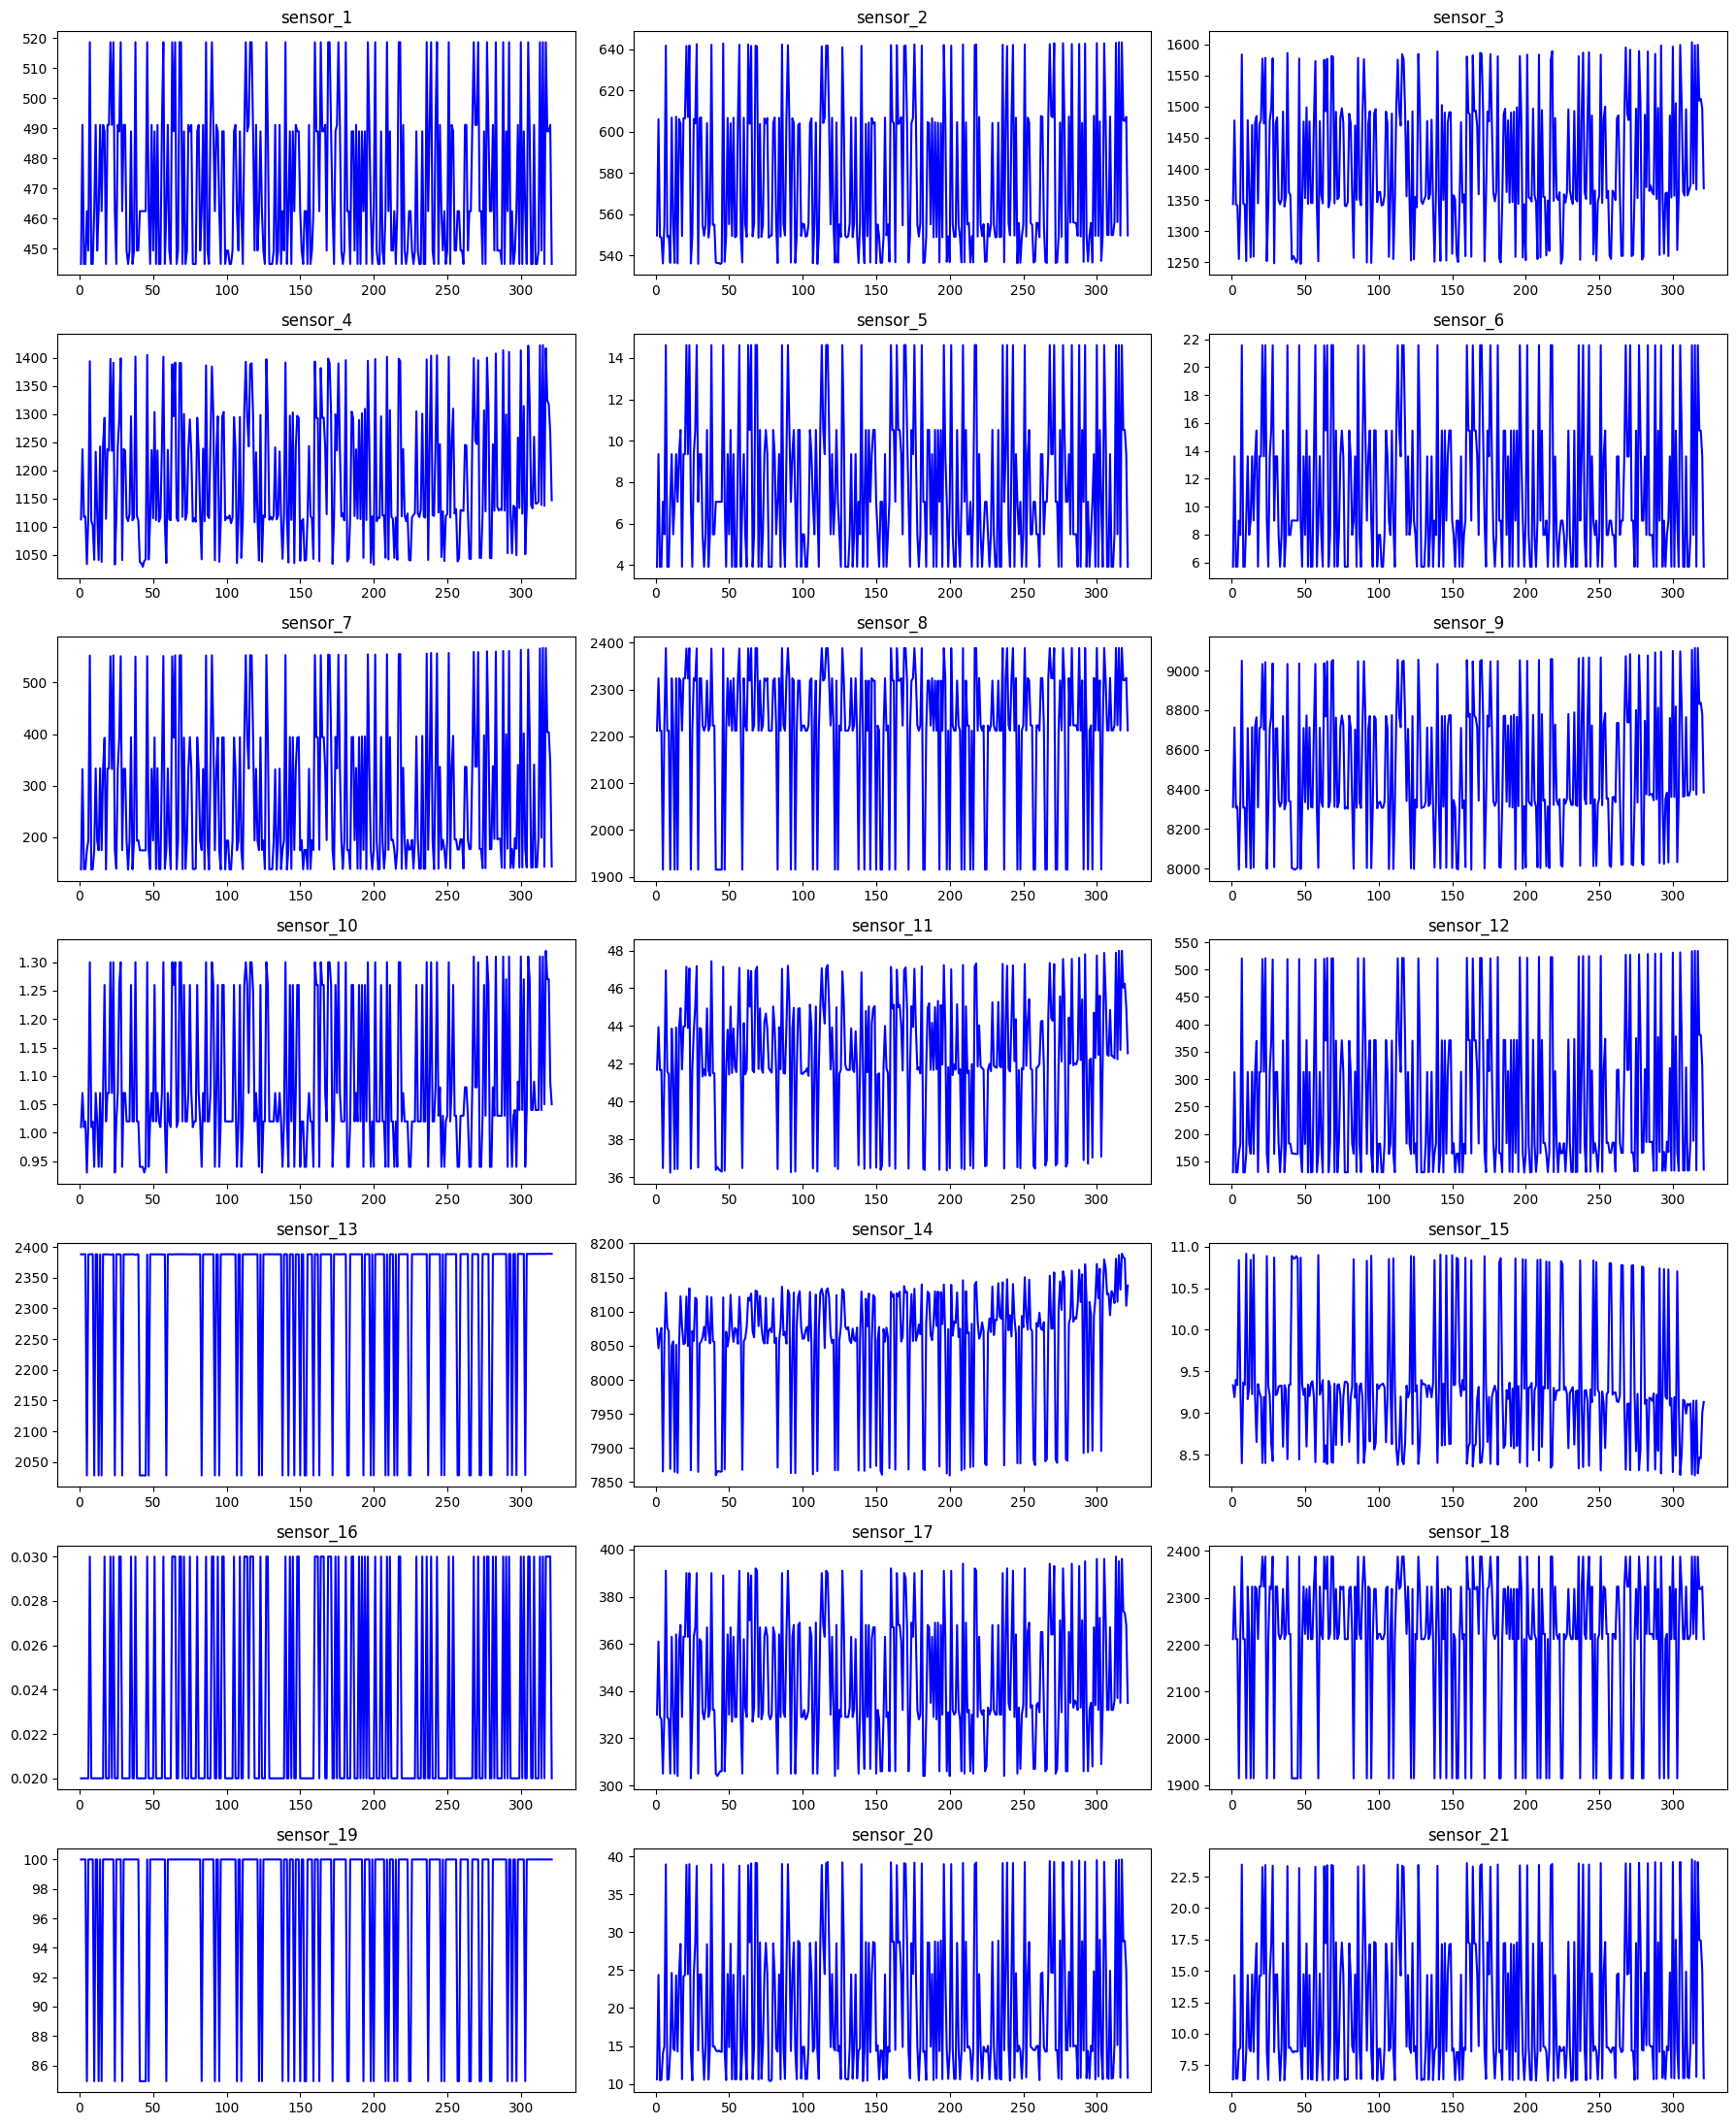

In [ ]:
# Exploratory Data Analysis (EDA) on FD004 TRAINING Data

print("\n Analyzing FD004 Training Data")
# Calculate Standard Deviations 
sensor_columns = [col for col in train_df.columns if col.startswith('sensor_')]
train_std = train_df[sensor_columns].std().sort_values()
print(" Sensor Standard Deviation (Train Data FD004)")
print(train_std)

# Plotting Individual Sensor Graphs
print(f"\n Individual Sensor Plots for Engine ID: 1 (Train Data FD004)")
train_engine_df = train_df[train_df['unit_nr'] == 1]
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(18, 22))
axes = axes.flatten()
for i, sensor in enumerate(sensor_columns):
    ax = axes[i]
    sns.lineplot(data=train_engine_df, x='time_cycles', y=sensor, ax=ax, color='blue')
    ax.set_title(sensor)
    ax.set_xlabel('')
    ax.set_ylabel('')
for j in range(len(sensor_columns), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [ ]:
# Feature Engineering and Preprocessing for FD004

# Identify and Drop Useless Sensors 
useless_sensors = train_std[train_std < 1].index.tolist()
print(f"\nIdentified {len(useless_sensors)} useless sensors for FD004:")
print(useless_sensors)

# Calculate RUL for Training Data 
max_cycles = train_df.groupby('unit_nr')['time_cycles'].max()
train_df['RUL'] = train_df.groupby('unit_nr')['time_cycles'].transform(lambda x: x.max() - x)

# Drop Useless Columns 
train_df_filtered = train_df.drop(columns=useless_sensors)
test_df_filtered = test_df.drop(columns=useless_sensors)

# Create Final Datasets and Scale
feature_cols = [col for col in train_df_filtered.columns if col in test_df_filtered.columns]
feature_cols = [col for col in feature_cols if col not in ['unit_nr', 'time_cycles', 'RUL']]

X_train = train_df_filtered[feature_cols]
y_train = train_df_filtered['RUL']
X_test = test_df_filtered.groupby('unit_nr').last()[feature_cols] # Select last cycle for prediction

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

print("\n--- Final Scaled FD004 Training Data ---")
print(X_train_scaled.head())

print("\n--- Final Scaled FD004 Test Data ---")
print(X_test_scaled.head())


Identified 3 useless sensors for FD004:
['sensor_16', 'sensor_10', 'sensor_15']

--- Final Scaled FD004 Training Data ---
   op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  sensor_3  \
0      0.999926      0.997625           1.0  0.000000  0.130347  0.272082   
1      0.476147      0.831591           1.0  0.626985  0.647971  0.634407   
2      0.999900      0.998694           1.0  0.000000  0.123646  0.271245   
3      0.999810      0.997625           1.0  0.000000  0.121351  0.266168   
4      0.595275      0.737173           0.0  0.238089  0.005691  0.033916   

   sensor_4  sensor_5  sensor_6  sensor_7  ...  sensor_9  sensor_11  \
0  0.212586  0.000000  0.001882  0.002738  ...  0.269578   0.458604   
1  0.511781  0.507937  0.498118  0.450787  ...  0.601411   0.641234   
2  0.222481  0.000000  0.001255  0.004625  ...  0.265759   0.456169   
3  0.224835  0.000000  0.001882  0.004164  ...  0.270428   0.457792   
4  0.022025  0.293184  0.208908  0.088924  ...  0.008603   

In [ ]:
# Train and Evaluate Random Forest Model on FD004
# Initialize and Train the Model 
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("\nTraining the model on FD004 data...")
model.fit(X_train_scaled, y_train)
print("Model training complete!")

# Make Predictions on the Test Data 
print("\nMaking predictions on the FD004 test data")
rul_predictions = model.predict(X_test_scaled)

# Evaluate the Model's Performance 
truth_path = os.path.join('..', 'data', 'FD004', 'RUL_FD004.txt')
truth_df = pd.read_csv(truth_path, header=None)
true_rul = truth_df[0]

rmse = np.sqrt(mean_squared_error(true_rul, rul_predictions))
print(f"\nModel Performance on FD004 (RMSE): {rmse:.2f}")

# Display Sample Predictions 
print("\nFirst 10 Predictions vs. True RUL for FD004:")
for i in range(10):
    print(f"Engine {i+1}: Predicted RUL = {rul_predictions[i]:.0f}, True RUL = {true_rul[i]}")



Training the model on FD004 data...
Model training complete!

Making predictions on the FD004 test data...

Model Performance on FD004 (RMSE): 42.92

First 10 Predictions vs. True RUL for FD004:
Engine 1: Predicted RUL = 53, True RUL = 22
Engine 2: Predicted RUL = 76, True RUL = 39
Engine 3: Predicted RUL = 85, True RUL = 107
Engine 4: Predicted RUL = 112, True RUL = 75
Engine 5: Predicted RUL = 58, True RUL = 149
Engine 6: Predicted RUL = 167, True RUL = 78
Engine 7: Predicted RUL = 129, True RUL = 94
Engine 8: Predicted RUL = 18, True RUL = 14
Engine 9: Predicted RUL = 80, True RUL = 99
Engine 10: Predicted RUL = 214, True RUL = 162


# LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
%matplotlib inline

DATASET_ID = 'FD004' 
column_names = ['unit_nr', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]

# Load training data
train_path = os.path.join('..', 'data', DATASET_ID, f'train_{DATASET_ID}.txt')
train_df = pd.read_csv(train_path, sep='\\s+', header=None, names=column_names)
train_df.dropna(axis=1, how='all', inplace=True)

# Load test data
test_path = os.path.join('..', 'data', DATASET_ID, f'test_{DATASET_ID}.txt')
test_df = pd.read_csv(test_path, sep='\\s+', header=None, names=column_names)
test_df.dropna(axis=1, how='all', inplace=True)

print(f"--- {DATASET_ID} Train and Test data loaded successfully ---")

In [ ]:
# Feature Engineering and Preprocessing
# Identify and Drop Useless Sensors
sensor_columns = [col for col in train_df.columns if 'sensor' in col]
train_std = train_df[sensor_columns].std()
useless_sensors = train_std[train_std < 1].index.tolist()
print(f"\nIdentified {len(useless_sensors)} useless sensors for {DATASET_ID}: {useless_sensors}")

train_df_filtered = train_df.drop(columns=useless_sensors)
test_df_filtered = test_df.drop(columns=useless_sensors)

# Calculate and Clip RUL for Training Data---
max_cycles = train_df_filtered.groupby('unit_nr')['time_cycles'].max()
train_df_filtered['RUL'] = train_df_filtered.groupby('unit_nr')['time_cycles'].transform(lambda x: x.max() - x)
train_df_filtered['RUL'] = train_df_filtered['RUL'].clip(upper=125) # Clipping RUL is a key step

# Create Final Datasets and Scale 
feature_cols = [col for col in train_df_filtered.columns if col in test_df_filtered.columns]
feature_cols = [col for col in feature_cols if col not in ['unit_nr', 'time_cycles', 'RUL']]

# For LSTM, we need the full timeseries for both train and test
X_train = train_df_filtered[feature_cols]
y_train = train_df_filtered['RUL']
X_test = test_df_filtered[feature_cols]

# Scale features
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Scale target variable (RUL)
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))

print("\n--- Data Scaled ---")

In [ ]:
# Reshape Data for LSTM
def create_sequences(input_data, target_data, sequence_length):
    X_sequences, y_sequences = [], []
    for i in range(len(input_data) - sequence_length + 1):
        X_sequences.append(input_data[i:(i + sequence_length)])
        y_sequences.append(target_data[i + sequence_length - 1])
    return np.array(X_sequences), np.array(y_sequences)

sequence_length = 50

# Reset indices to align data for filtering
train_df_filtered.reset_index(drop=True, inplace=True)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols)

# Create sequences for training data
X_train_reshaped, y_train_reshaped = [], []
for unit_nr in train_df_filtered['unit_nr'].unique():
    unit_data = X_train_scaled_df[train_df_filtered['unit_nr'] == unit_nr]
    unit_target = y_train_scaled[train_df_filtered['unit_nr'] == unit_nr]
    X, y = create_sequences(unit_data.values, unit_target, sequence_length)
    if X.shape[0] > 0:
        X_train_reshaped.append(X)
        y_train_reshaped.append(y)

X_train_final = np.concatenate(X_train_reshaped)
y_train_final = np.concatenate(y_train_reshaped)

# Create a scaled test DataFrame and align its index
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_cols, index=test_df_filtered.index)

# Create sequences for test data (last sequence for each engine)
X_test_reshaped = []
for unit_nr in test_df_filtered['unit_nr'].unique():
    unit_data = X_test_scaled_df[test_df_filtered['unit_nr'] == unit_nr]
    last_sequence_values = unit_data.values
    if len(last_sequence_values) < sequence_length:
        padding = np.zeros((sequence_length - len(last_sequence_values), last_sequence_values.shape[1]))
        last_sequence = np.concatenate([padding, last_sequence_values])
    else:
        last_sequence = last_sequence_values[-sequence_length:]
    X_test_reshaped.append(last_sequence)

X_test_final = np.array(X_test_reshaped)

print("--- Data Reshaped for LSTM ---")
print("Training data shape:", X_train_final.shape)
print("Test data shape:", X_test_final.shape)

--- FD004 Train and Test data loaded successfully ---

Identified 3 useless sensors for FD004: ['sensor_10', 'sensor_15', 'sensor_16']

--- Data Scaled ---
--- Data Reshaped for LSTM ---
Training data shape: (49048, 50, 21)
Test data shape: (248, 50, 21)

Training the LSTM model on FD004 data...


c:\Users\Dell\Desktop\Uniconverge\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - loss: 0.0633 - val_loss: 0.0339
Epoch 2/20
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 110s 76ms/step - loss: 0.0365 - val_loss: 0.0282
Epoch 3/20
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 70s 51ms/step - loss: 0.0285 - val_loss: 0.0198
Epoch 4/20
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 0.0263 - val_loss: 0.0190
Epoch 5/20
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 72s 52ms/step - loss: 0.0237 - val_loss: 0.0210
Epoch 6/20
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 74s 53ms/step - loss: 0.0230 - val_loss: 0.0191
Epoch 7/20
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 75s 54ms/step - loss: 0.0209 - val_loss: 0.0161
Epoch 8/20
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 78s 56ms/step - loss: 0.0209 - val_loss: 0.0214
Epoch 9/20
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 105s 76ms/step - loss: 0.0203 - val_loss: 0.0151
Epoch 10/20
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 157s 114ms/step - loss: 0.0192 - val_loss: 0.0164
Epoch 11/20
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 125s 90ms/step - loss: 0.0186 - val_loss: 0.0208
Epo

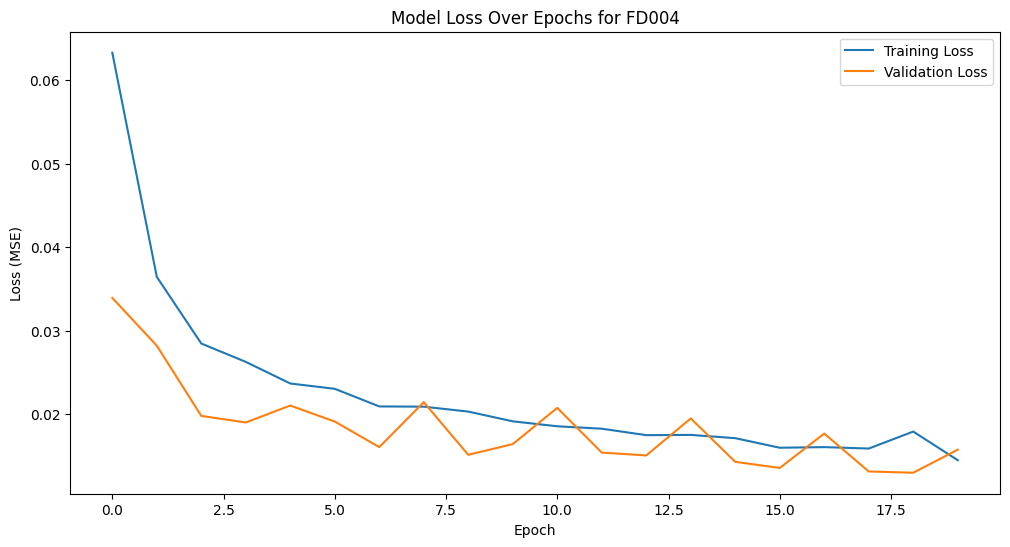

In [ ]:
# Build, Train, and Evaluate LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Training
print(f"\nTraining the LSTM model on {DATASET_ID} data...")
history = model_lstm.fit(X_train_final, y_train_final, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate
rul_predictions_scaled = model_lstm.predict(X_test_final)
rul_predictions_lstm = target_scaler.inverse_transform(rul_predictions_scaled)

truth_path = os.path.join('..', 'data', DATASET_ID, f'RUL_{DATASET_ID}.txt')
truth_df = pd.read_csv(truth_path, header=None)
true_rul = truth_df[0]

rmse_lstm = np.sqrt(mean_squared_error(true_rul, rul_predictions_lstm))
print(f"\nLSTM Model Performance on {DATASET_ID} (RMSE): {rmse_lstm:.2f}")

print("\nFirst 10 Predictions vs. True RUL (LSTM):")
for i in range(10):
    print(f"Engine {i+1}: Predicted RUL = {rul_predictions_lstm[i][0]:.0f}, True RUL = {true_rul[i]}")

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Model Loss Over Epochs for {DATASET_ID}')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()